## Testing pre-trained model: Resnet50v2

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from datetime import datetime

2024-05-08 15:47:49.811980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 15:47:49.812101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 15:47:50.092095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1. Loading the datasets

In [3]:
train_ds, val_ds = image_dataset_from_directory(
    directory='/kaggle/input/emotion-detection-fer/train/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Using 5741 files for validation.


In [4]:
test_ds = image_dataset_from_directory(
    directory='/kaggle/input/emotion-detection-fer/test/',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 7178 files belonging to 7 classes.


### 2. Preprocessing data

In [5]:
def preprocess_data(img, label):
    return preprocess_input(img), label

preproc_test_ds = test_ds.map(preprocess_data)
preproc_train_ds = train_ds.map(preprocess_data)
preproc_val_ds = val_ds.map(preprocess_data)

### 3. Loading ResNet50v2 model

In [6]:
in_shape = train_ds.element_spec[0].shape[1:]
in_tensor = layers.Input(shape = in_shape)

def loading_model():
    model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=in_shape)

    return model

In [7]:
model = loading_model()
model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

#### a. Adding layers

In [8]:
def add_layers(model):

    base_model = model
    base_model.trainable = False

    aug1 = layers.RandomFlip("horizontal")
    aug2 = layers.RandomRotation(0.1)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(7, activation='softmax')

    model = models.Sequential([
            layers.Input(shape = in_shape),
            base_model,
            aug1, aug2,
            flatten_layer,
            dense_layer,
            prediction_layer
        ])
    return model

In [9]:
model = loading_model()
model = add_layers(model)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 7, 7, 2048)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    50,176,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,744,807 (281.31 MB)

 Trainable params: 50,180,007 (191.42 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [11]:
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,     # for model improvement: play with decay_steps([100, 3])
    decay_rate=0.99,    #
    staircase=True)
lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)


optimizer = Adam(learning_rate=0.0001)

In [12]:
formatted_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

In [13]:
# mcp = ModelCheckpoint("{}.h5".format(MODEL),
#                       monitor='val_loss',
#                       mode='auto',
#                       verbose=0,
#                       save_best_only=True)

mcp = ModelCheckpoint("{}resnet50v2.weights.h5".format(formatted_time),
                      monitor='val_loss',
                      mode='auto',
                      verbose=0,
                      save_best_only=True,
                      save_weights_only = True)

#### b. Building the model

In [14]:
def build_model():
 
    model = loading_model()
    model = add_layers(model)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [15]:
model = build_model()

### 4. Training the model

In [16]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 3, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(preproc_train_ds, 
                    validation_data=preproc_val_ds, 
                    epochs=100, 
                    callbacks=[es, lr, mcp])

Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 137s 171ms/step - accuracy: 0.4356 - loss: 1.6981 - val_accuracy: 0.5323 - val_loss: 1.2501 - learning_rate: 1.0000e-04
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 118s 164ms/step - accuracy: 0.5761 - loss: 1.1510 - val_accuracy: 0.5482 - val_loss: 1.2154 - learning_rate: 1.0000e-04
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 115s 160ms/step - accuracy: 0.6292 - loss: 1.0077 - val_accuracy: 0.5445 - val_loss: 1.2749 - learning_rate: 1.0000e-04
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6766 - loss: 0.8979
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
718/718 ━━━━━━━━━━━━━━━━━━━━ 115s 160ms/step - accuracy: 0.6766 - loss: 0.8978 - val_accuracy: 0.5652 - val_loss: 1.2591 - learning_rate: 1.0000e-04
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 117s 163ms/step - accuracy: 0.7244 - loss: 0.7771 - val_accuracy: 0.5774 - val_loss: 1.1846 - learning_rate: 1.0000e-05
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 1

### 4. Checking the accuracy and loss plots

In [17]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

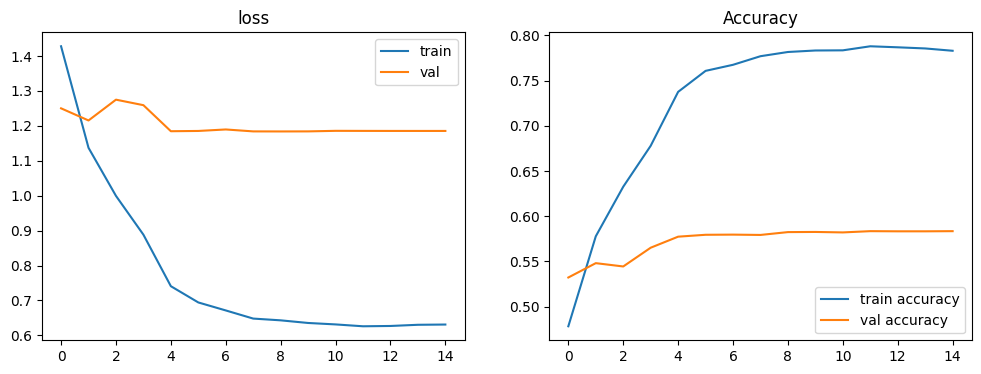

In [18]:
plot_history(history)

### 5. Evaluating the model with test dataset

In [19]:
test_eval = model.evaluate(preproc_test_ds)

225/225 ━━━━━━━━━━━━━━━━━━━━ 27s 115ms/step - accuracy: 0.5913 - loss: 1.1802


### 6. Manual model saving
* model could be saved in keras format only (h5 format failed to be saved)

In [39]:
from tensorflow import keras
# keras.saving.save_model(model, filepath='/kaggle/working/resnet50v2_model.h5', 
#                         save_format='h5')
model.save('/kaggle/working/2024_05_18_resnet50v2_model.keras')

In [22]:
# from google.cloud import storage

# BUCKET_NAME = "gs://resnet50v2"

# # storage_filename = "models/xgboost_model.joblib"
# # local_filename = "model.joblib"

# client = storage.Client(project = "le-wagon-bootcamp-1621")
# bucket = client.bucket(BUCKET_NAME)
# # blob = bucket.blob(storage_filename)
# # blob.download_to_filename(local_filename)

# blob = bucket.blob("models/240508_resnet50v2_model.keras")
# blob.upload_from_filename("240508_resnet50v2_model.keras")

### 7. Model prediction of a given image

In [24]:
from tensorflow import tile
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow import expand_dims # Add a batch dimension


#### a. preprocessing and image formatting

In [25]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = img_to_array(image)
    #rgb_image = tile(image, [1, 1, 3])
    image_expanded = expand_dims(image, axis=0)
    image = preprocess_input(image_expanded)
    return image

In [26]:
image_path = "/kaggle/input/img-surprised-1/surprised.jpg"
img = load_and_preprocess_image(image_path=image_path, target_size = (224,224))

In [27]:
img.shape

TensorShape([1, 224, 224, 3])

#### b. predicting the image

In [28]:
output = model.predict(img)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [32]:
class_names = train_ds.class_names
class_names
# print(class_names[np.argmax(output)], np.max(output))

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [33]:
for k, v in dict(zip(class_names, output.flatten().tolist())).items():
    print(f"{k}: {round(100*v, 1)} %")

angry: 0.5 %
disgusted: 0.0 %
fearful: 8.5 %
happy: 0.4 %
neutral: 0.9 %
sad: 3.7 %
surprised: 86.0 %


### 8. Loading the saved model_weights 
* The model weights were saved during the mcp = ModelCheckpoint(), see above!
* We should be able to load and use the model_weights by usin the model.load_weights() function, after instanciating the model as below

In [48]:
#load the model weights
model_loaded= build_model()
model_loaded.load_weights('2024_05_08_15_48_27resnet50v2.weights.h5')

In [51]:
#checking the loaded model
model_loaded.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_2 (RandomFlip)      │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 7, 7, 2048)     │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │    50,176,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,104,823 (664.16 MB)

 Trainable params: 50,180,007 (191.42 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 100,360,016 (382.84 MB)

#### a. Re-using the model for predicting the same given image, above

In [54]:
output_model_loaded = model_loaded.predict(img)
output_model_loaded

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[5.3995354e-03, 1.8112570e-06, 7.1861506e-02, 3.4376772e-03,
        8.1968782e-03, 3.1541865e-02, 8.7956071e-01]], dtype=float32)

In [55]:
for k, v in dict(zip(class_names, output_model_loaded.flatten().tolist())).items():
    print(f"{k}: {round(100*v, 1)} %")

angry: 0.5 %
disgusted: 0.0 %
fearful: 7.2 %
happy: 0.3 %
neutral: 0.8 %
sad: 3.2 %
surprised: 88.0 %
